Dataset shape: (21799, 27)

First few rows:
        patient_id   age  sex  height  weight  nurse  site     device  \
ecg_id                                                                  
1          15709.0  56.0    1     NaN    63.0    2.0   0.0  CS-12   E   
2          13243.0  19.0    0     NaN    70.0    2.0   0.0  CS-12   E   
3          20372.0  37.0    1     NaN    69.0    2.0   0.0  CS-12   E   
4          17014.0  24.0    0     NaN    82.0    2.0   0.0  CS-12   E   
5          17448.0  19.0    1     NaN    70.0    2.0   0.0  CS-12   E   

             recording_date                                  report  ...  \
ecg_id                                                               ...   
1       1984-11-09 09:17:34  sinusrhythmus periphere niederspannung  ...   
2       1984-11-14 12:55:37     sinusbradykardie sonst normales ekg  ...   
3       1984-11-15 12:49:10              sinusrhythmus normales ekg  ...   
4       1984-11-15 13:44:57              sinusrhythmus normales 

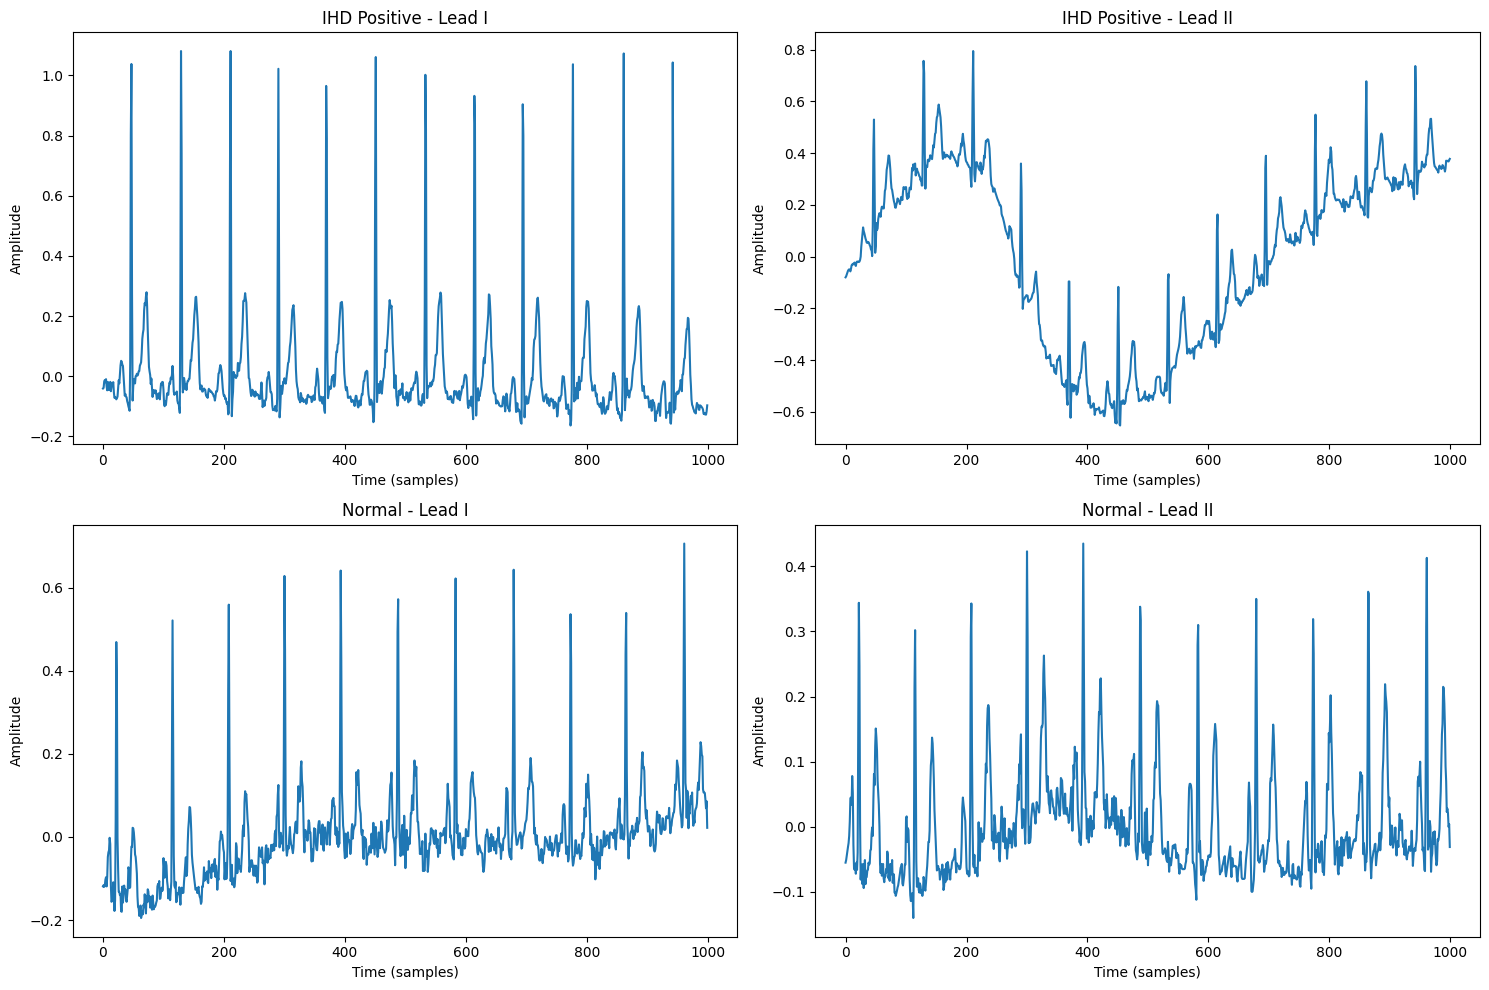


Dataset Statistics:
Total samples: 21799
IHD positive: 5469
Normal: 16330
Signal duration: 10.0 seconds
Number of leads: 12
Sampling rate: 100 Hz

Demographics:

Age distribution:
           count       mean        std   min   25%   50%   75%    max
has_IHD                                                              
0        16330.0  59.866687  30.209675   2.0  46.0  59.0  71.0  300.0
1         5469.0  71.436277  36.546728  15.0  58.0  67.0  76.0  300.0

Gender distribution:
sex             0         1
has_IHD                    
0        0.486650  0.513350
1        0.622966  0.377034

Saving data to /scratch1/e20-fyp-ecg-ihd-detection/experiments/baseline_cnn_lstm/data/...

Data saved successfully!
Files: X_raw.npy (2.09 GB), Y_labels.csv


In [1]:
# PTB-XL ECG Dataset - Data Loading and Exploration
# Notebook 1: Initial Setup and Data Exploration
# For the SERVER Environment

import numpy as np
import pandas as pd
import wfdb
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# ==========================================
# 1. LOAD PTB-XL DATASET
# ==========================================

def load_raw_data(df, sampling_rate, path):
    """Load raw ECG signals"""
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path + f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path + f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

# Load metadata
#path = '../data/'  # Update this path to your dataset location
path = '/scratch1/e20-fyp-ecg-ihd-detection/data/raw/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/'

Y = pd.read_csv(path + 'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

print(f"Dataset shape: {Y.shape}")
print(f"\nFirst few rows:")
print(Y.head())

# ==========================================
# 2. LOAD DIAGNOSTIC LABELS
# ==========================================

# Load SCP statements (diagnostic labels)
agg_df = pd.read_csv(path + 'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    """Aggregate diagnostic labels"""
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic aggregation
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

# ==========================================
# 3. FILTER FOR IHD (Ischemic Heart Disease)
# ==========================================

# IHD is typically classified under 'MI' (Myocardial Infarction) or 'STTC' (ST/T Change)
# Filter data with IHD-related diagnoses
Y['has_IHD'] = Y['diagnostic_superclass'].apply(lambda x: 1 if 'MI' in x else 0)

print(f"\n{'='*50}")
print(f"IHD Distribution:")
print(Y['has_IHD'].value_counts())
print(f"IHD Percentage: {Y['has_IHD'].mean()*100:.2f}%")

# ==========================================
# 4. LOAD ECG SIGNALS (100Hz sampling rate)
# ==========================================

print(f"\nLoading ECG signals (this may take a few minutes)...")
X = load_raw_data(Y, 100, path)
print(f"ECG signals shape: {X.shape}")
print(f"(samples, timesteps, leads) = ({X.shape[0]}, {X.shape[1]}, {X.shape[2]})")

# ==========================================
# 5. DATA EXPLORATION AND VISUALIZATION
# ==========================================

# Plot example ECG signals
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# IHD positive example
ihd_idx = Y[Y['has_IHD'] == 1].index[0]
ihd_sample = X[Y.index.get_loc(ihd_idx)]

axes[0, 0].plot(ihd_sample[:, 0])  # Lead I
axes[0, 0].set_title('IHD Positive - Lead I')
axes[0, 0].set_xlabel('Time (samples)')
axes[0, 0].set_ylabel('Amplitude')

axes[0, 1].plot(ihd_sample[:, 1])  # Lead II
axes[0, 1].set_title('IHD Positive - Lead II')
axes[0, 1].set_xlabel('Time (samples)')
axes[0, 1].set_ylabel('Amplitude')

# Normal example
normal_idx = Y[Y['has_IHD'] == 0].index[0]
normal_sample = X[Y.index.get_loc(normal_idx)]

axes[1, 0].plot(normal_sample[:, 0])  # Lead I
axes[1, 0].set_title('Normal - Lead I')
axes[1, 0].set_xlabel('Time (samples)')
axes[1, 0].set_ylabel('Amplitude')

axes[1, 1].plot(normal_sample[:, 1])  # Lead II
axes[1, 1].set_title('Normal - Lead II')
axes[1, 1].set_xlabel('Time (samples)')
axes[1, 1].set_ylabel('Amplitude')

plt.tight_layout()
plt.savefig('/scratch1/e20-fyp-ecg-ihd-detection/experiments/baseline_cnn_lstm/results/figures/ecg_examples.png', dpi=300, bbox_inches='tight')
plt.show()

# ==========================================
# 6. STATISTICAL SUMMARY
# ==========================================

print(f"\n{'='*50}")
print("Dataset Statistics:")
print(f"{'='*50}")
print(f"Total samples: {len(Y)}")
print(f"IHD positive: {Y['has_IHD'].sum()}")
print(f"Normal: {(Y['has_IHD']==0).sum()}")
print(f"Signal duration: {X.shape[1]/100} seconds")
print(f"Number of leads: {X.shape[2]}")
print(f"Sampling rate: 100 Hz")

# Age and gender distribution
print(f"\n{'='*50}")
print("Demographics:")
print(f"{'='*50}")
print(f"\nAge distribution:")
print(Y.groupby('has_IHD')['age'].describe())
print(f"\nGender distribution:")
print(pd.crosstab(Y['has_IHD'], Y['sex'], normalize='index'))

# ==========================================
# 7. SAVE PREPROCESSED DATA
# ==========================================

# Save for next notebook
output_dir = '/scratch1/e20-fyp-ecg-ihd-detection/experiments/baseline_cnn_lstm/data/'

print(f"\nSaving data to {output_dir}...")
np.save(output_dir + 'X_raw.npy', X)
Y.to_csv(output_dir + 'Y_labels.csv')

print(f"\n{'='*50}")
print("Data saved successfully!")
print(f"Files: X_raw.npy ({X.nbytes / 1e9:.2f} GB), Y_labels.csv")
print(f"{'='*50}")